In [18]:
import requests
import torch
import torch.nn as nn
import os
from torchvision import models
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision import transforms
from torch import optim
from matplotlib import pyplot as plt
import skimage
from tqdm import tqdm
import torchsummary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.imgs_tensors = []
        self.labels_tensors = []

        self.transform = transform

    def compute_transform(self):
        self.imgs_tensors = []
        self.labels_tensors = []

        for img in self.imgs:
            img = (transforms.functional.pil_to_tensor(img).float() / 255.0)
            if len(img.shape) == 2:
                img = torch.stack((img,)*3, axis=-1)
            elif img.shape[0] == 1:
                img = torch.cat((img,)*3, axis=0)
            self.imgs_tensors.append(img)

        for label in self.labels:
            label_tensor = torch.tensor(label)
            self.labels_tensors.append(label_tensor)

    def __getitem__(self, index) -> tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs_tensors[index]
        label = self.labels_tensors[index]

        if self.transform:
            img = self.transform(img)

        return id_, img, label

    def __len__(self):
        return len(self.ids)

In [4]:
test_transform = v2.Compose([
    v2.Normalize([0.2980, 0.2962, 0.2987], [0.2886, 0.2875, 0.2889]),
    v2.Resize((32, 32))
])

train_transform = v2.Compose([
    v2.Resize((32, 32)),

    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(20),
    v2.RandomAffine(0, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=0.05),

    v2.RandomChoice([
        v2.GaussianBlur(3),
        v2.GaussianBlur(5),
        lambda x: x
    ], p=[0.1, 0.1, 0.8]),

    v2.Normalize([0.2980, 0.2962, 0.2987], [0.2886, 0.2875, 0.2889]),
])

In [5]:
train_dataset = torch.load('Train.pt', weights_only=False)
train_dataset.transform = train_transform
train_dataset.compute_transform()

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True)

In [7]:
# labels = {}

# for _, img, label in tqdm(train_dataset):
#     label_value = int(label.item())
#     if label_value not in labels:
#         labels[label_value] = 1
#     else:
#         labels[label_value] += 1

labels = {
    8: 31802,
    2: 23356,
    5: 14886,
    4: 7036,
    1: 9171,
    7: 409,
    9: 4706,
    3: 3568,
    6: 4642,
    0: 424
}

In [8]:
labels

{8: 31802,
 2: 23356,
 5: 14886,
 4: 7036,
 1: 9171,
 7: 409,
 9: 4706,
 3: 3568,
 6: 4642,
 0: 424}

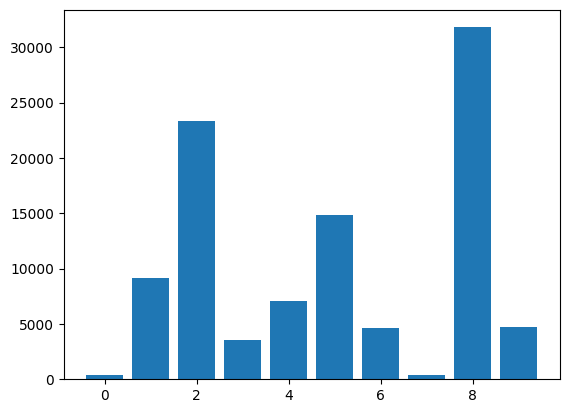

In [9]:
plt.bar(labels.keys(), labels.values())
plt.show()

In [10]:
# def get_features(img: np.ndarray) -> np.ndarray:
#     # img_gray = img.mean(axis=2)
#     img_sobel_x = skimage.filters.sobel_h(img)
#     img_sobel_y = skimage.filters.sobel_v(img)
#     img_sobel = np.sqrt(img_sobel_x ** 2 + img_sobel_y ** 2)
#     return img_sobel

# counter_colours = 0

# for _, img, label in train_dataset:
#     img_np = np.array(img)
#     if len(img_np.shape) == 2:
#         continue

#     dif = img_np[:, :, 0] - img_np[:, :, 1]
#     dif_2 = img_np[:, :, 1] - img_np[:, :, 2]
#     # if np.any(dif != 0) or np.any(dif_2 != 0):
#     #     # print('Found')
#     #     # print(dif.sum())
#     #     # print(dif_2.sum())
#     #     plt.imshow(dif)
#     #     plt.show()
#     #     counter_colours += 1
#     # print(img_np[: ,: ,0] - img_np[: ,: ,1], img_np[: ,: ,1] - img_np[: ,: ,2])

#     dif_real = np.abs(dif) + np.abs(dif_2)
#     is_object = dif_real > 1
#     # img_sobel = get_features(dif_real)
#     # img_sobel_sum = img_sobel.sum()

    
#     # if img_sobel_sum < 30:
#     #     continue

#     countours_found = skimage.measure.find_contours(is_object, 0.5)
    
#     if len(countours_found) == 0:
#         continue
#     print(countours_found)
    
#     plt.imshow(is_object)
#     plt.show()

#     # plt.title(f'{img_sobel_sum} {label}')
#     # plt.imshow(img_sobel)
#     # plt.show()
#     plt.imshow(img_np)
#     plt.show()
    

# print(counter_colours)
# print(len(train_dataset))

In [11]:
model = models.resnet18(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 10).to(device)

/net/tscratch/people/tutorial004/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/net/tscratch/people/tutorial004/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
total_count = sum(labels.values())
class_weights = [total_count / labels[label] for label in sorted(labels.keys())]
class_weights = torch.tensor(class_weights).to(device)
print(class_weights)

tensor([235.8491,  10.9039,   4.2816,  28.0269,  14.2126,   6.7177,  21.5424,
        244.4988,   3.1445,  21.2495], device='cuda:0')


In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [19]:
def train(model: nn.Module, optimizer: optim.Optimizer, criterion, train_dataloader: DataLoader,
          epochs: int, epsilon: float = 0.01, alpha: float = 0.5):
    loss_history = []
    accuracy_history = []
    
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total = 0

        model.train()
        for id_, img, label in tqdm(train_dataloader):
            img = img.to(device)
            label = label.to(device)

            # img.requires_grad = True

            optimizer.zero_grad()
            outputs = model(img)

            # lowest_class = outputs.argmin(axis=1)
            # lowest_class_loss = criterion(outputs, lowest_class)
            # lowest_class_loss.backward(retain_graph=True)
            # new_img = img + epsilon * torch.sign(img.grad)

            # outputs_new = model(new_img)
            loss = alpha * criterion(outputs, label)# + (1 - alpha) * criterion(outputs_new, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            total_correct += (predicted == label).sum().item()

            total += len(label)

        avg_loss = total_loss / total
        accuracy = total_correct / total
        print(f'Epoch: {epoch} Loss: {avg_loss} Accuracy: {accuracy}')
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

    return loss_history, accuracy_history

In [21]:
loss_history, acc_history = train(model, optimizer, criterion, train_dataloader, 2)

for param in model.layer4.parameters():
    param.requires_grad = True

loss_history_new, acc_history_new = train(model, optimizer, criterion, train_dataloader, 20)
loss_history += loss_history_new
acc_history += acc_history_new

for param in model.layer3.parameters():
    param.requires_grad = True

loss_history_new, acc_history_new = train(model, optimizer, criterion, train_dataloader, 30)
loss_history += loss_history_new
acc_history += acc_history_new

for param in model.layer2.parameters():
    param.requires_grad = True

loss_history_new, acc_history_new = train(model, optimizer, criterion, train_dataloader, 40)
loss_history += loss_history_new
acc_history += acc_history_new

100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 87.46it/s]


Epoch: 0 Loss: 0.004300143235325814 Accuracy: 0.5312


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 89.01it/s]


Epoch: 1 Loss: 0.0041301077684760094 Accuracy: 0.54093


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 89.17it/s]


Epoch: 0 Loss: 0.004136888377666474 Accuracy: 0.54362


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 91.48it/s]


Epoch: 1 Loss: 0.004096948882341385 Accuracy: 0.54698


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 89.01it/s]


Epoch: 2 Loss: 0.004080575917065144 Accuracy: 0.55013


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:09<00:00, 86.37it/s]


Epoch: 3 Loss: 0.004054425373673439 Accuracy: 0.55191


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 87.58it/s]


Epoch: 4 Loss: 0.004054087252914906 Accuracy: 0.54937


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 89.23it/s]


Epoch: 5 Loss: 0.004023235460817814 Accuracy: 0.55397


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 90.69it/s]


Epoch: 6 Loss: 0.0040217251273989675 Accuracy: 0.55822


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 87.22it/s]


Epoch: 7 Loss: 0.003984970298707485 Accuracy: 0.55597


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 89.97it/s]


Epoch: 8 Loss: 0.00397030341565609 Accuracy: 0.55986


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 91.15it/s]


Epoch: 9 Loss: 0.0039380763626098636 Accuracy: 0.56158


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 86.96it/s]


Epoch: 10 Loss: 0.003957518102973699 Accuracy: 0.56081


100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 90.41it/s]


Epoch: 11 Loss: 0.003916550622582436 Accuracy: 0.56287


  0%|                                                                                 | 0/782 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x146e18d062a0>
Traceback (most recent call last):
  File "/net/tscratch/people/tutorial004/ai/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:08<00:00, 89.23it/s]


Epoch: 12 Loss: 0.003914352546930313 Accuracy: 0.56416


 49%|███████████████████████████████████▏                                   | 387/782 [00:04<00:05, 78.23it/s]


KeyboardInterrupt: 